In [1]:
import numpy as np
from scipy import linalg as la
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%run camera_functions
%matplotlib inline

# Hartley-Sturm Algorithm (1997)
* Input: 
    * $n$ randomly scattered 3D points
    * Two cameras, positions known
* Output: 
    * Optimal 3D triangulation

In [2]:
def compute_view_matrix(position, target, up):
    '''
    Inputs: 
        position : 3D coordinates of the camera center in world coordinates
        target : 3D coordinates of the camera target in world coordinates
        up : vector specifying the up direction of the camera. should be orthogonal to (target-position)
    Outputs:
        P : 3 x 4 camera extrinsic matrix, a concatenation of rotation matrix and translation matrix
    '''
    L = target - position
    L = L / np.linalg.norm(L)
    s = np.cross(L, up)
    s = s / np.linalg.norm(s)
    u_prime = np.cross(s,L)
    R = np.r_[s,u_prime,-L].reshape((3,3))
    T = -R @ position
    P = np.c_[R,T]
    return P

def project(position,target,up,X):
    '''
    Given camera extrinsic details, and 3D points X, 
    return the homogenous coordinates of Y,
    which are projected into the camera plane.
    See compute_view_matrix() details
    '''
    P = compute_view_matrix(position,target,up)
    if len(X.shape) > 1:
        _,n = X.shape
        Y = P @ np.r_[X,np.ones((1,n))]
        Y /= Y[2,:]
        return Y
    else:
        Y = P @ np.r_[X,1]
        Y /= Y[2]
        return Y

def fundamental_matrix(Y,Yp):
    '''
    Inputs:
        Y : all keypoints from camera 1 in homogenous coordinates in a (3 x n_kp) matrix
        Yp : same from camera 2
    Outputs:
        F : fundamental matrix between stereo cameras
    Desc:
        Solved using the 7-point algorithm. It is assumed that matching keypoints are aligned
        by column. At least 7 matches required. 
    TODO: 
        Implement normalized version. Camera intrinsics needed?
    '''
    n = Y.shape[1]
    X = np.zeros((n,9))
    for i in range(n):
        X[i] = np.outer(Yp[:,i],Y[:,i]).flatten()
        
    U,S,Vh = la.svd(X)
    F = Vh[len(Vh)-1].reshape((3,3))
    U,S,Vh = la.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ Vh
    return F

In [46]:
def rigid_normalize(x,e):
    # Transform x to be at the origin and compute L
    L = np.eye(3)
    L[:2,2] = -x[:2]
#     e = L @ e
    # Find rotation theta by using the epipolar line
    theta = np.arctan( - (e[1] - e[2] * x[1]) / (e[0] - e[2] * x[0]) )
    R = np.array( [ [np.cos(theta), -np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1] ] )
    T = R @ L
    # Enforce that RLe[0] = 1
#     T /= (T @ e)[0]
#     print( (T @ e)[2])
    print( (T @ e)[2] / (T @ e)[0])
    return T
    

In [27]:
def fundamental_normalize(x,xp,e,ep,F0):
    '''
    Calculate the fundamental matrix between a pair of points that are
    normalized to be at the origin, and for the epipoles normalized to
    be on the x axis
    '''
    print('f = ')
    T = rigid_normalize(x,e)
    print('f\' = ')
    Tp = rigid_normalize(xp,ep)
#     F = Tp @ F0 @ la.pinv(T)
    F = la.pinv(Tp.T) @ F0 @ la.pinv(T)
    return T,Tp,F
    

In [5]:
def hartley_sturm_single_point(x,xp,e,ep,F0):
    T,Tp,F = fundamental_normalize(x,xp,e,ep,F0)
    
    a = F[1,1]
    b = F[1,2]
    c = F[2,1]
    d = F[2,2]
    f = -F[2,0] / d
    fp = -F[0,2] / d
    print('From the fundamental matrix:')
    print('f = ', f)
    print('f\'= ', fp)
    
    alpha = a**2 + fp**2 * c**2
    beta = 2*a*b + 2*c*d*fp**2
    gamma = b**2 + d**2 * fp**2
    
    # coefficients are co0 through co6
    co6 = a*c*f**4
    co5 = a*b*f**4 + b*c*f**4 + alpha
    co4 = b*d*f**4 + 2*a*c*f**2 + 2*alpha*beta
    co3 = 2*a*d*f**2 + 2*b*c*f**2 + 2*alpha*gamma + beta**2
    co2 = a*c + 2*b*d*f**2 + 2*beta*gamma
    co1 = b*c + a*d + gamma**2
    co0 = b*d
    
    # Find real roots, accounting for some numerical instability
    r = np.roots(np.array([co6,co5,co4,co3,co2,co1,co0]))
    r_real = r[np.abs(np.imag(r)) <= 0.01]
    r_real = np.real(r_real)
    if len(r_real) == 0:
        print("No real roots found")
        print("Returning vector of roots for inspection")
        return r
    
    s = lambda t : t**2 / ( 1 + (t*f)**2 ) + ( c*t + d )**2 / ( (a*t + b)**2 + fp**2 * (c*t + d)**2 )
    # Solve s at the real roots and take the minimum
    sr = s(r_real)
    t = r_real[np.argmin(sr)]
    return t

# Begin Simulation
* Scatter Random 3D Points
* Define Camera Positions
* Project 2D Points
* Calculate epipoles
* Calculate Fundamental Matrix

In [6]:
# n Target points 
n = 10
X = np.random.uniform(-3,3,(3,n))

cam1_pos = np.array([-5,-5,0])
cam1_tgt = np.array([0,0,0])
cam1_up = np.array([0,0,1])
Y1 = project(cam1_pos, cam1_tgt, cam1_up, X)

cam2_pos = np.array([-5,5,1])
cam2_tgt = np.array([0,0,0])
cam2_up = np.array([0,-1,5])
Y2 = project(cam2_pos, cam2_tgt, cam2_up, X)

e = project(cam1_pos, cam1_tgt, cam1_up, cam2_pos)
ep = project(cam2_pos, cam2_tgt, cam2_up, cam1_pos)

In [7]:
print(e,ep)

[ 1.         -0.14142136  1.        ] [-0.98058068 -0.13730876  1.        ]


In [8]:
P1 = compute_view_matrix(cam1_pos,cam1_tgt,cam1_up)
P2 = compute_view_matrix(cam2_pos,cam2_tgt,cam2_up)
e1 = P1 @ np.r_[cam2_pos,1]
e2 = P2 @ np.r_[cam1_pos,1]
print(e1,e2)

[-7.07106781  1.         -7.07106781] [ 7.00274671  0.98058068 -7.14142843]


In [50]:
F0 = fundamental_matrix(Y1,Y2)
e1_norm = e1 / la.norm(e1[:2])
e2_norm = e2 / la.norm(e2[:2])
T1,T2,F = fundamental_normalize(Y1[:,0],Y2[:,0],e1,e2,F0)
print(F0)
print(F)
print(T1 @ e1)
print(T2 @ e2)

f = 
0.8170680068723477
f' = 
-1.3107936753955978
[[ 1.36627322e-03  5.02372550e-01  6.96799341e-02]
 [ 4.97614263e-01 -3.05311332e-16 -4.97614263e-01]
 [ 6.96665380e-02  4.92616815e-01  1.24900090e-16]]
[[ 3.99715555e-16  5.01312573e-01 -1.94289029e-16]
 [ 4.98666419e-01  4.18400187e-03 -6.10312012e-01]
 [ 2.02785787e-16  3.82449643e-01 -5.55111512e-17]]
[-8.65419739  0.         -7.07106781]
[ 5.44817126e+00 -4.44089210e-16 -7.14142843e+00]


In [51]:
print( F @ (T1 @ e1) ) 
print( T2 @ e2 @ F)
print(T2 @ Y2[:,0])
print(T1 @ Y1[:,0])
print((T2 @ Y2[:,0]).T @ F @ (T1 @ Y1[:,0]))

[-2.08538641e-15  0.00000000e+00 -1.36242512e-15]
[ 5.08086237e-16  9.48427344e-16 -3.91058013e-16]
[0. 0. 1.]
[0. 0. 1.]
-5.551115123125783e-17


In [52]:
print(-F[0,2] / F[2,2])
print(-F[0,1] / F[2,1])
print(-F[1,0] / F[1,2])
print(-F[2,0] / F[2,2])

-3.5
-1.3107936753955982
0.8170680068723478
3.653063984800737


In [13]:
print(e)
print(ep)

[ 1.         -0.14142136  1.        ]
[-0.98058068 -0.13730876  1.        ]


In [14]:
t = hartley_sturm_single_point(Y1[:,0],Y2[:,0],e,ep,F0)
print(t)

f = 
0.6712967587992348
f' = 
-0.7541094909721898
From the fundamental matrix:
f =  1.3425935175984707
f'=  0.9399621015161145
-0.3335134852781318


## Debugging stuff below here

In [16]:
T,Tp,F = fundamental_normalize(Y1[:,0],Y2[:,0],e,ep,F0)
print(F)
a = F[1,1]
b = F[1,2]
c = F[2,1]
d = F[2,2]
f = -F[2,0] / d
fp = -F[0,2] / d
print(a,b,c,d,f,fp)

f = 
0.6712967587992348
f' = 
-0.7541094909721898
[[-0.03234103 -0.46355737  0.09927798]
 [-0.57792444  0.08008265  0.70248111]
 [ 0.14180356 -0.54060509 -0.10561913]]
0.0800826452459424 0.7024811132798476 -0.5406050860666637 -0.10561913372330964 1.3425935175984707 0.9399621015161145


In [17]:
print(F @ np.array([1,0,f]))
print(np.array([1,0,fp]) @ F)

[0.10094894 0.36522215 0.        ]
[ 1.00948942e-01 -9.71705661e-01  3.65343819e-18]


In [120]:
print(F0 @ e)
print(ep @ F0)
print(np.array([0,0,1]) @ F @ np.array([0,0,1]))

[-4.16333634e-17 -1.99840144e-15 -3.19189120e-16]
[-2.63677968e-16  4.44089210e-16  3.08255762e-16]
0.22525421325766157


In [114]:
print(T @ Y1[:,0])
print(Tp @ Y2[:,0])
print(T @ e)
print(Tp @ ep)

[0.         0.         0.71780805]
[ 6.93889390e-18 -2.77555756e-17 -9.79967834e-01]
[1.         0.         0.71780805]
[ 1.00000000e+00  2.77555756e-17 -9.79967834e-01]


<Figure size 432x288 with 0 Axes>

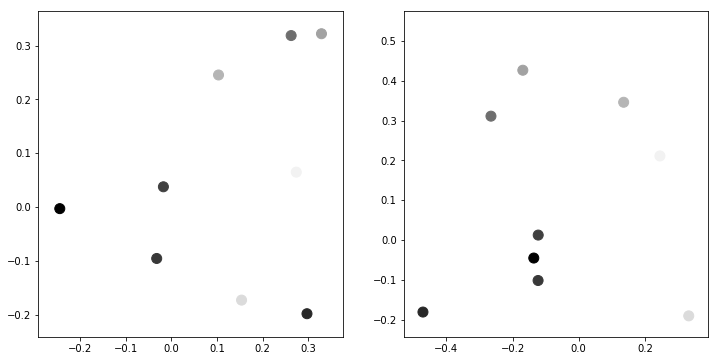

In [50]:
plt.gray()
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(Y1[0,:],Y1[1,:],c=X[1,:],s=100)
ax = fig.add_subplot(122)
ax.scatter(Y2[0,:],Y2[1,:],c=X[1,:],s=100)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

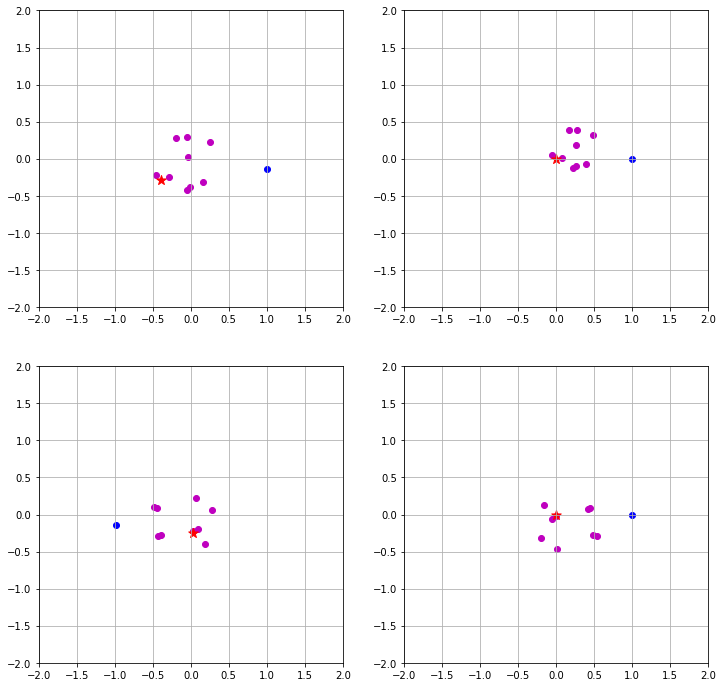

In [116]:
fig = plt.figure(figsize=(12,12))
ax= fig.add_subplot(221)
# Pre-normalization
ax.scatter(Y1[0,1:],Y1[1,1:],c='m') # regular points
ax.scatter(Y1[0,0],Y1[1,0],c='r',marker='*',s=100) # normalizing point
ax.scatter(e[0],e[1],c='b') # epipole
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.grid(True)
# Post-normalization
Y1n = T @ Y1
en = T @ e
ax = fig.add_subplot(222)
ax.scatter(Y1n[0,1:],Y1n[1,1:],c='m') # regular points
ax.scatter(Y1n[0,0],Y1n[1,0],c='r',marker='*',s=100) # normalizing point
ax.scatter(en[0],en[1],c='b') # epipole
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.grid(True)
# Pre-normalization
ax = fig.add_subplot(223)
ax.scatter(Y2[0,1:],Y2[1,1:],c='m') # regular points
ax.scatter(Y2[0,0],Y2[1,0],c='r',marker='*',s=100) # normalizing point
ax.scatter(ep[0],ep[1],c='b') # epipole
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.grid(True)
# Post-normalization
Y2n = Tp @ Y2
epn = Tp @ ep
ax = fig.add_subplot(224)
ax.scatter(Y2n[0,1:],Y2n[1,1:],c='m') # regular points
ax.scatter(Y2n[0,0],Y2n[1,0],c='r',marker='*',s=100) # normalizing point
ax.scatter(epn[0],epn[1],c='b') # epipole
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.grid(True)

plt.show

In [74]:
f = 1.0238424305833052
fp = -.822070923513809
a = F[1,1]
b = F[1,2]
c = F[2,1]
d = F[2,2]
# print(f*fp*d)
# print(-fp*c)
# print(-fp*d)
# print(-f*b)
# print(-f*d)
print(F[0,0] / f / d)
print(-F[0,1] / c)
print(-F[0,2] / d)
print(F)

0.1463939557657704
-0.8467515254185236
0.19080000909980313
[[-0.02195851 -0.40984859  0.02795278]
 [-0.52439245  0.11414333  0.66754193]
 [ 0.11508653 -0.48402463 -0.14650303]]
